In [1]:
import numpy as np
import numpy.random as nr 
import scipy.io as sio

### Generate mixture of Gaussian


#### easy model

In [463]:
nr.seed(0)
n = 100
d = 2

all_etr = np.array([[],[]]).T
all_elb = np.array([])


for i in range(11):

    ebin_ = nr.choice(2, n, p = [0.9, 0.1])
    ebin1 = nr.choice(2, np.sum(ebin_), p = [0.8, 0.2])
    ebin0 = nr.choice(2, n - np.sum(ebin_), p = [0.8, 0.2])

    emean0 = (-1,-1)
    emean1 = (0,0)
    emean2 = (1,1)

    en01 = np.sum(ebin0)
    en00 = n - np.sum(ebin_) - en01
    en11 = np.sum(ebin1)
    en10 = np.sum(ebin_) - en11

    etr00 = nr.multivariate_normal(emean0, np.identity(d), en00)
    etr01 = nr.multivariate_normal(emean1, np.identity(d), en01)
    etr10 = nr.multivariate_normal(emean2, np.identity(d), en10)
    etr11 = nr.multivariate_normal(emean1, np.identity(d), en11)

    etr0 = np.append(etr00, etr01, axis = 0)
    etr1 = np.append(etr10, etr11, axis = 0)

    el0 = np.array([0 for i in range(len(etr0))])
    el1 = np.array([1 for i in range(len(etr1))])

    etr = np.append(etr0,etr1,axis = 0)
    elb = np.append(el0,el1, axis = 0)
    
    
    all_etr = np.append(all_etr, etr, axis = 0)
    all_elb = np.append(all_elb, elb, axis = 0)
    

In [466]:
sio.savemat('mix_gaussian_easy_train',{'train':all_etr, 'label': all_elb})

#### difficult model

In [665]:
nr.seed(0)

all_dtr = np.array([[],[]]).T
all_dlb = np.array([])


for i in range(11):
    dbin_ = nr.choice(2, n, p = [0.9, 0.1])
    dbin0 = nr.choice(3, n - np.sum(dbin_), p = [0.4, 0.4, 0.2])

    dmean0 = (-0.5,0)
    dmean1 = (0,-1)
    dmean2 = (1, 0)
    dmean3 = (0, 1)

    dn1 = np.sum(dbin_)
    dn01 = np.sum(dbin0 == 0)
    dn02 = np.sum(dbin0 == 1)
    dn03 = np.sum(dbin0 == 2) 

    dtr1 = nr.multivariate_normal(dmean0, np.identity(d), dn1)
    dtr01 = nr.multivariate_normal(dmean1, np.identity(d), dn01)
    dtr02 = nr.multivariate_normal(dmean2, np.identity(d), dn02)
    dtr03 = nr.multivariate_normal(dmean3, np.identity(d), dn03)

    dtr0 = np.append(np.append(dtr01, dtr02, axis = 0), dtr03, axis = 0)


    dl0 = np.array([0 for i in range(len(dtr0))])
    dl1 = np.array([1 for i in range(len(dtr1))])

    dtr = np.append(dtr0,dtr1,axis = 0)
    dlb = np.append(dl0,dl1, axis = 0)
    
    all_dtr = np.append(all_dtr, dtr, axis = 0)
    all_dlb = np.append(all_dlb, dlb, axis = 0)


In [666]:
sio.savemat('mix_gaussian_diff',{'train':all_dtr, 'label': all_dlb})

#### Import data

In [668]:
easy = sio.loadmat('mix_gaussian_easy_train')
diff = sio.loadmat('mix_gaussian_diff')

In [669]:
elb = easy['label'][0,]
etr = easy['train']
dtr = diff['train']
dlb = diff['label'][0,]

### Soft-Margin SVM

In [474]:
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#### 10-fold Cross-Validation

We use 10-fold Cross-Validation in order to decide hyper-paramter. 

In [476]:
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

In [590]:
def cv_linearSVM (X, y, penalty, n_folds):
    n = len(X)
    kf = KFold(n, n_folds)
    accuracy = []

    total_gmean = 0 
    for train_index, test_index in kf:
        X_train, X_test = X[train_index,: ], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = svm.SVC(kernel='linear', C=penalty)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
        
        gmean = np.sqrt(a1 * a0)
        total_gmean += gmean
    return np.mean(total_gmean)

#### Easy Model
It is when penalty = 1.5 that we have highest average accuracy from cross validation.

In [940]:
n = 100
ran_ind = nr.choice(n,n,replace=False)
etr0 = etr[0:100,:][ran_ind,:]
elb0 = elb[0:100][ran_ind]

In [592]:
cv_linearSVM(etr0,elb0,1,10)

4.7071067811865479

In [593]:
cv_linearSVM(etr0,elb0,0.1,10)

0.0

In [594]:
cv_linearSVM(etr0,elb0,10,10)

4.7071067811865479

In [595]:
cv_linearSVM(etr0,elb0,100,10)

4.6614378277661475

In [596]:
cv_linearSVM(etr0,elb0,200,10)

4.6614378277661475

In [597]:
cv_linearSVM(etr0,elb0,50,10)

4.6614378277661475

In [598]:
cv_linearSVM(etr0,elb0,5,10)

4.7071067811865479

In [599]:
cv_linearSVM(etr0,elb0,3,10)

4.7071067811865479

In [600]:
cv_linearSVM(etr0,elb0,0.5,10)

4.6614378277661475

#### Graph and Confusion Matrix

In [309]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(['negative','positive']))
    plt.xticks(tick_marks, ['negative','positive'])
    plt.yticks(tick_marks, ['negative','positive'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


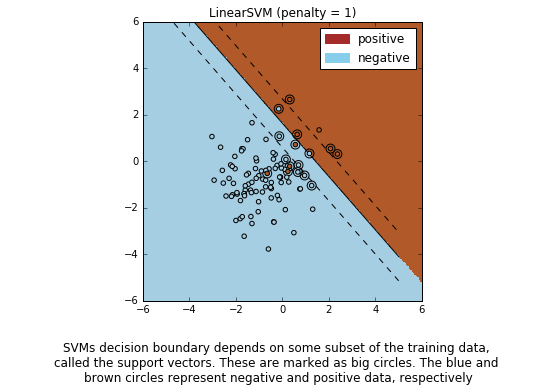

In [770]:
penalty = 1
clf = svm.SVC(kernel='linear', C=penalty)
clf.fit(etr[0:100, :],elb[0:100])

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]
fignum=1
# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy + a * margin
yy_up = yy - a * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(5, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10)
plt.scatter(etr[0:100, 0], etr[0:100, 1], c=elb[0:100], zorder=10, cmap=plt.cm.Paired, s = 20)

plt.axis('tight')
x_min = -6
x_max = 6
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(fignum, figsize=(6, 6))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


#plt.xticks(())
#plt.yticks(())


brown_patch = mpatches.Patch(color='brown', label='positive')
sky_patch = mpatches.Patch(color='skyblue', label='negative')
plt.legend(handles=[brown_patch, sky_patch])
plt.title("LinearSVM (penalty = 1)")
plt.figtext(0.5, -0.1,'''SVMs decision boundary depends on some subset of the training data, 
                        called the support vectors. These are marked as big circles. The blue and 
                        brown circles represent negative and positive data, respectively''',
            wrap=True,horizontalalignment='center', fontsize=12)

plt.savefig('easy_linearSVM.png', bbox_inches='tight')



[[90  2]
 [ 4  4]]


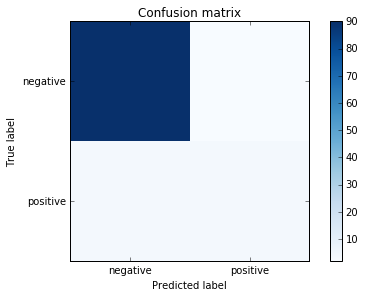

In [771]:
# Compute confusion matrix
epred = clf.predict(etr[1000:1100,:])
ecm_linearSVM = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)
print(ecm_linearSVM)
plt.figure()
plot_confusion_matrix(ecm_linearSVM)
plt.savefig('Confusion_easy_linearSVM.png', bbox_inches='tight')

In numeric table, the confusion matrix is as follows.

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 90            | 2        |
| positive      | 4             | 4        |



#### Average metrics of evaluation

In [778]:
def avg_linearSVM (X, y, penalty):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]


        clf = svm.SVC(kernel='linear', C=penalty)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [780]:
elinearSVM_gmean, elinearSVM_accur, elinearSVM_fmeas = avg_linearSVM(etr, elb, 1)

In [781]:
np.mean(elinearSVM_gmean)

0.27809292163621152

In [782]:
np.mean(elinearSVM_accur)

0.91888888888888909

In [783]:
np.mean(elinearSVM_fmeas)

0.95727858843484404

#### Difficult model

In [680]:
n = 100
ran_ind = nr.choice(n,n,replace=False)
dtr0 = dtr[0:100,:][ran_ind,:]
dlb0 = dlb[0:100][ran_ind]

In [681]:
cv_linearSVM(dtr0,dlb0,1,10)

0.0

In [682]:
cv_linearSVM(dtr0,dlb0,100,10)

0.0

In [683]:
cv_linearSVM(dtr0,dlb0,10,10)

0.0

In [684]:
cv_linearSVM(dtr0,dlb0,5,10)

0.0

In [685]:
cv_linearSVM(dtr0,dlb0,200,10)

0.0

In [686]:
cv_linearSVM(dtr0,dlb0,20,10)

0.0

In [687]:
cv_linearSVM(dtr0,dlb0,0.0000001,10)

0.0

In [688]:
cv_linearSVM(dtr0,dlb0,1e-7,10)

0.0

#### Graph and Confusion Matrix

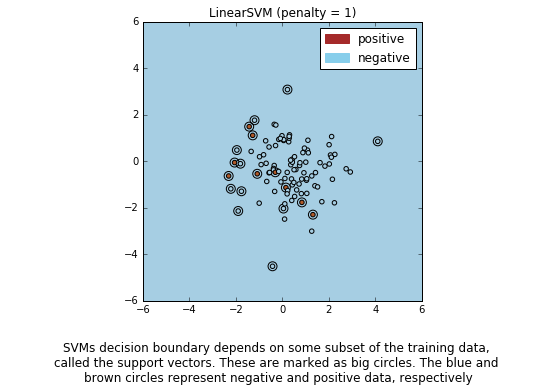

In [750]:
penalty = 1
clf = svm.SVC(kernel='linear', C=penalty)
clf.fit(dtr0, dlb0)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]
fignum=1
# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy + a * margin
yy_up = yy - a * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(5, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10)
plt.scatter(dtr0[:, 0], dtr0[:, 1], c=dlb0, zorder=10, cmap=plt.cm.Paired, s = 20)

plt.axis('tight')
x_min = -6
x_max = 6
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(fignum, figsize=(6, 6))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


#plt.xticks(())
#plt.yticks(())


brown_patch = mpatches.Patch(color='brown', label='positive')
sky_patch = mpatches.Patch(color='skyblue', label='negative')
plt.legend(handles=[brown_patch, sky_patch])
plt.title("LinearSVM (penalty = 1)")
plt.figtext(0.5, -0.1,'''SVMs decision boundary depends on some subset of the training data, 
                        called the support vectors. These are marked as big circles. The blue and 
                        brown circles represent negative and positive data, respectively''',
            wrap=True,horizontalalignment='center', fontsize=12)

plt.savefig('diff_linearSVM.png', bbox_inches='tight')

[[70 24]
 [ 5  1]]


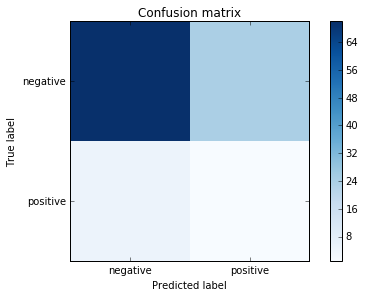

In [697]:
# Compute confusion matrix
dpred = clf.predict(dtr[1000:1100,:])
dcm_linearSVM = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)
print(dcm_linearSVM)

plt.figure()
plot_confusion_matrix(dcm_linearSVM)
plt.savefig('Confusion_diff_linearSVM.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 70            | 24       |
| positive      | 5             | 1        |



#### Average metrics of evaluation

In [784]:
dlinearSVM_gmean, dlinearSVM_accur, dlinearSVM_fmeas = avg_linearSVM(dtr, dlb, 1)

In [785]:
np.mean(dlinearSVM_gmean)

0.0

In [786]:
np.mean(dlinearSVM_accur)

0.93999999999999995

In [787]:
np.mean(dlinearSVM_fmeas)

0.9690721649484535

### k-Nearest Neighborhood 

In [165]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

#### 10-fold Cross-Validation



In [703]:
def cv_kNN (X, y, k, n_folds):
    n = len(X)
    kf = KFold(n, n_folds)
    total_gmean = 0

    for train_index, test_index in kf:
        X_train, X_test = X[train_index,: ], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = KNeighborsClassifier(n_neighbors= k, weights = 'uniform')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
        
        gmean = np.sqrt(a1 * a0)
        total_gmean += gmean
    return np.mean(total_gmean)

#### Easy Model

It is when k = 1 that the model results in the highest average accuracy from cross validation.

In [621]:
cv_kNN(etr0, elb0, 1, 10)

4.6499158227686106

In [622]:
cv_kNN(etr0, elb0, 3, 10)

3.4861639730364082

In [623]:
cv_kNN(etr0, elb0, 5, 10)

2.0

In [624]:
cv_kNN(etr0, elb0, 7, 10)

2.0

In [625]:
cv_kNN(etr0, elb0, 11, 10)

2.0

In [626]:
cv_kNN(etr0, elb0, 9, 10)

2.0

In [704]:
cv_kNN(etr0, elb0, 19, 10)

0.0

#### Graph and Confusion Matrix

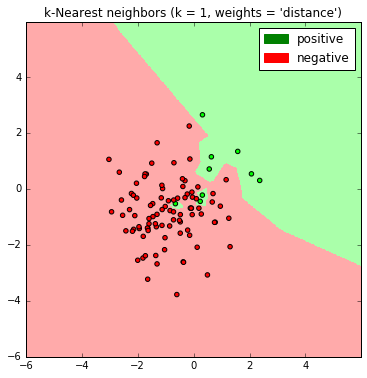

In [628]:


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


# we create an instance of Neighbours Classifier and fit the data.
eneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')
eneigh.fit(etr0, elb0) 

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = eneigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(etr0[:, 0], etr0[:, 1], c=elb0, cmap=cmap_bold, s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-Nearest neighbors (k = %i, weights = '%s')"
          % (1, 'distance'))

green_patch = mpatches.Patch(color='green', label='positive')
red_patch = mpatches.Patch(color='red', label='negative')
plt.legend(handles=[green_patch, red_patch])

plt.savefig('easy_kNN.png', bbox_inches='tight')

[[85  7]
 [ 6  2]]


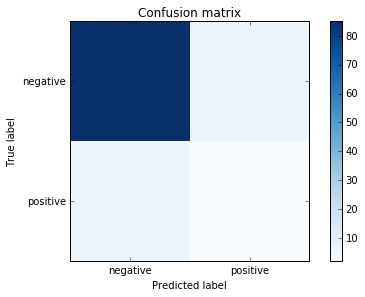

In [629]:
epred = eneigh.predict(etr[1000:1100,:])
ecm_kNN = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)

print(ecm_kNN)
plt.figure()
plot_confusion_matrix(ecm_kNN)
plt.savefig('Confusion_easy_kNN.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 85            | 7        |
| positive      | 6             | 2        |

#### Average metrics of evaluation

In [789]:
def avg_kNN (X, y, k):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]


        clf = KNeighborsClassifier(n_neighbors= k, weights = 'uniform')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [790]:
ekNN_gmean, ekNN_accur, ekNN_fmeas = avg_kNN(etr,elb, 1)

In [792]:
np.mean(ekNN_gmean)

0.42953083477258214

In [793]:
np.mean(ekNN_accur)

0.89999999999999991

In [794]:
np.mean(ekNN_fmeas)

0.94619813392245555

#### Difficult model

In [707]:
cv_kNN(dtr0, dlb0, 1, 10)

1.0

In [706]:
cv_kNN(dtr0, dlb0, 3, 10)

0.0

In [708]:
cv_kNN(dtr0, dlb0, 5, 10)

0.0

In [709]:
cv_kNN(dtr0, dlb0, 11, 10)

0.0

In [710]:
cv_kNN(dtr0, dlb0, 15, 10)

0.0

In [711]:
cv_kNN(dtr0, dlb0, 21, 10)

0.0

#### Graph and Confusion Matrix

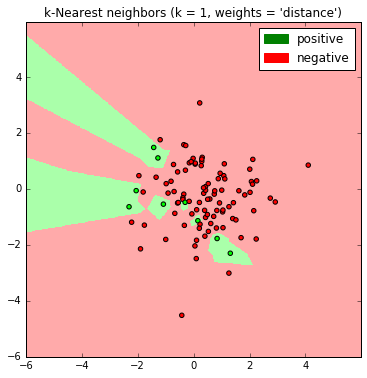

In [712]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


# we create an instance of Neighbours Classifier and fit the data.
dneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')
dneigh.fit(dtr0, dlb0) 

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = dneigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(dtr0[:, 0], dtr0[:, 1], c=dlb0, cmap=cmap_bold, s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-Nearest neighbors (k = %i, weights = '%s')"
          % (1, 'distance'))

green_patch = mpatches.Patch(color='green', label='positive')
red_patch = mpatches.Patch(color='red', label='negative')
plt.legend(handles=[green_patch, red_patch])


plt.savefig('diff_kNN.png', bbox_inches='tight')

[[84 10]
 [ 5  1]]


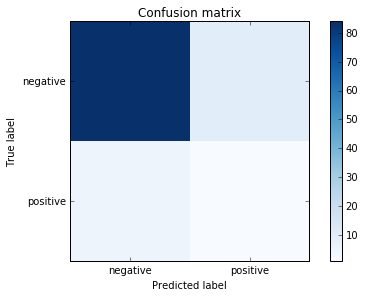

In [713]:

dpred = dneigh.predict(dtr[1000:1100,:])
dcm_kNN = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)

print(dcm_kNN)
plt.figure()
plot_confusion_matrix(dcm_kNN)
plt.savefig('Confusion_diff_kNN.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 84            | 10       |
| positive      | 5             | 1        |

#### Average metrics of evaluation

In [796]:
dkNN_gmean, dkNN_accur, dkNN_fmeas = avg_kNN(dtr, dlb, 1)

In [797]:
np.mean(dkNN_gmean)

0.38117497103809805

In [798]:
np.mean(dkNN_accur)

0.87222222222222223

In [799]:
np.mean(dkNN_fmeas)

0.93063120046755088

### Adaboost


#### Easy Model

#### Graph and Confusion Matrix

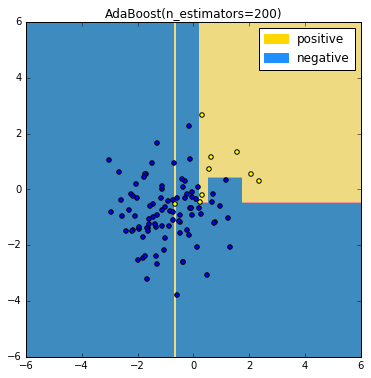

In [643]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Create and fit an AdaBoosted decision tree
ebdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

ebdt.fit(etr0, elb0)

plot_colors = ['blue','yellow']
plot_step = 0.02



# Plot the decision boundaries
plt.figure()
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = ebdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, c in zip(range(2), plot_colors):
    idx = np.where(elb0 == i)
    plt.scatter(etr0[idx, 0], etr0[idx, 1], c=c)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

gold_patch = mpatches.Patch(color='gold', label='positive')
blue_patch = mpatches.Patch(color='dodgerBlue', label='negative')
plt.legend(handles=[gold_patch, blue_patch])

plt.title('AdaBoost(n_estimators=200)')

plt.savefig('easy_Adaboost.png', bbox_inches='tight')

[[86  6]
 [ 4  4]]


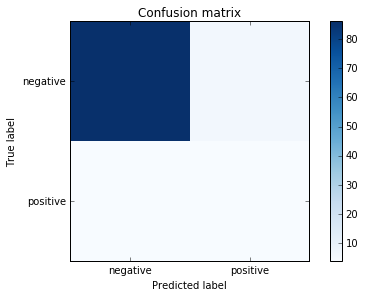

In [648]:
epred = ebdt.predict(etr[1000:1100, :])
ecm_bdt = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)

print(ecm_bdt)
plt.figure()
plot_confusion_matrix(ecm_bdt)
plt.savefig('Confusion_easy_AdaBoost.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 86            | 6        |
| positive      | 4             | 4        |

#### Average metrics of evaluation

In [1035]:
def avg_AdaBoost (X, y):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]

        bdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

        bdt.fit(X_train, y_train)
        y_pred = bdt.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [1036]:
eAdaBoost_gmean, eAdaBoost_accur, eAdaBoost_fmeas = avg_AdaBoost(etr, elb)

In [1037]:
np.mean(eAdaBoost_gmean)

0.52559140106370261

In [1038]:
np.mean(eAdaBoost_accur)

0.90111111111111108

In [1039]:
np.mean(eAdaBoost_fmeas)

0.94646397686896711

#### Difficult Model

#### Graph and Confusion Matrix

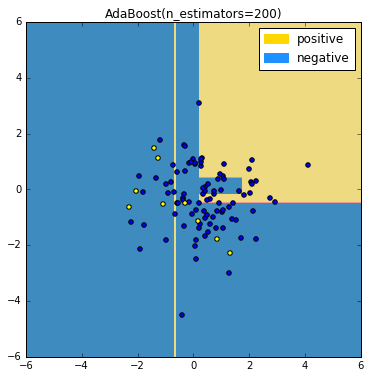

In [714]:
# Create and fit an AdaBoosted decision tree
dbdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

dbdt.fit(etr0, elb0)

plot_colors = ['blue','yellow']
plot_step = 0.02



# Plot the decision boundaries
plt.figure()
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = dbdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, c in zip(range(2), plot_colors):
    idx = np.where(dlb0 == i)
    plt.scatter(dtr0[idx, 0], dtr0[idx, 1], c=c)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

gold_patch = mpatches.Patch(color='gold', label='positive')
blue_patch = mpatches.Patch(color='dodgerBlue', label='negative')
plt.legend(handles=[gold_patch, blue_patch])

plt.title('AdaBoost(n_estimators=200)')

plt.savefig('diff_Adaboost.png', bbox_inches='tight')

[[70 24]
 [ 5  1]]


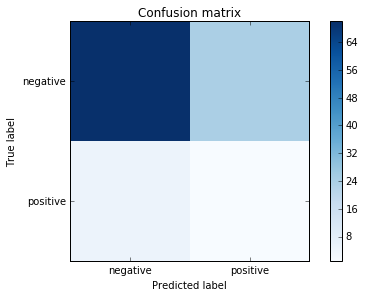

In [715]:
dpred = dbdt.predict(dtr[1000:1100,:])
dcm_bdt = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)

print(dcm_bdt)
plt.figure()
plot_confusion_matrix(dcm_bdt)
plt.savefig('Confusion_diff_AdaBoost.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 70            | 24       |
| positive      | 5             | 1        |

#### Average metrics of evaluation

In [1040]:
dAdaBoost_gmean, dAdaBoost_accur, dAdaBoost_fmeas = avg_AdaBoost(dtr, dlb)

In [1041]:
np.mean(dAdaBoost_gmean)

0.42097511027641105

In [1042]:
np.mean(dAdaBoost_accur)

0.85555555555555562

In [1043]:
np.mean(dAdaBoost_fmeas)

0.92037923195699889

# Spam data

In [400]:
spam_data = sio.loadmat('spam_data.mat')

In [405]:
sp_ft = spam_data['training_data']
sp_lb = spam_data['training_labels'][0,:]

### Preprocessing

In [651]:
m = len(sp_ft)

In [722]:
sran_ind = nr.choice(m,m,replace = False)
sp_ft = sp_ft[sran_ind,:]
sp_lb = sp_lb[sran_ind]

In [723]:
bin_sp_ft = (sp_ft > 0) * 1

In [724]:
spvl_ft = bin_sp_ft[4000:5172,:]
sptr_ft = bin_sp_ft[:4000,:]
spvl_lb = sp_lb[4000:5172]
sptr_lb = sp_lb[:4000]

In [725]:
bin_sp_ft.shape

(5172, 32)

### LinearSVM

In [726]:
cv_linearSVM(sptr_ft,sptr_lb,1,10)

7.2767893784439561

In [727]:
cv_linearSVM(sptr_ft,sptr_lb,10,10)

7.2802722548382679

In [728]:
cv_linearSVM(sptr_ft,sptr_lb,0.1,10)

7.1782743518242782

In [729]:
cv_linearSVM(sptr_ft,sptr_lb,20,10)

7.2789290560462803

In [730]:
cv_linearSVM(sptr_ft,sptr_lb,15,10)

7.2802722548382679

[[775  51]
 [141 205]]


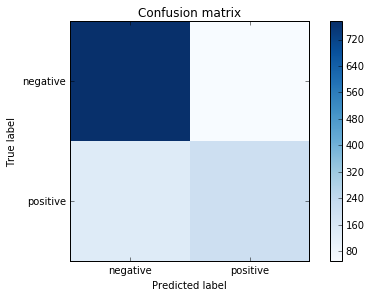

In [731]:
penalty = 10
sclf = svm.SVC(kernel='linear', C=penalty)
sclf.fit(sptr_ft, sptr_lb)
# Compute confusion matrix
spred = sclf.predict(spvl_ft)
scm_linearSVM = confusion_matrix(spvl_lb, spred)
np.set_printoptions(precision=2)
print(scm_linearSVM)

plt.figure()
plot_confusion_matrix(scm_linearSVM)
plt.savefig('Confusion_spam_linearSVM.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 775            | 51      |
| positive      | 141            | 20      |

#### metrics of evaluation

In [812]:
def metrics(cm):
    if cm.shape == (1,1):
        new_cm = np.zeros((2,2))
        new_cm[0,0] = cm[0,0]
        cm = new_cm
    if cm[0,0]+ cm[1,0] == 0:
        a1 = 0
    else:

        a1 = cm[0,0]/(cm[0,0] + cm[1,0])
    if cm[1,1]+ cm[0,1] == 0:
        a0 = 0
    else:
        a0 = cm[1,1]/(cm[0,1] + cm[1,1])

    if cm[0,0]+ cm[0,1] == 0:
        p = 0
    else:
        p = cm[0,0]/(cm[0,0] + cm[0,1])

    if a1 + p == 0:
        f = 0
    else:
        f = (2 * p * a1)/(a1 + p)
    fmeas = f
    gmean = np.sqrt(a1 * a0)
    accur = (cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])

    return gmean, accur, fmeas

In [813]:
metrics(scm_linearSVM.T)

(0.74558937197071395, 0.83617747440273038, 0.88978185993111369)

### kNN

In [733]:
cv_kNN(sptr_ft, sptr_lb, 1, 10)

6.7415877571801666

In [734]:
cv_kNN(sptr_ft, sptr_lb, 3, 10)

7.3535907549657011

In [735]:
cv_kNN(sptr_ft, sptr_lb, 5, 10)

7.3429176755334931

In [736]:
cv_kNN(sp_ft, sp_lb, 7, 10)

7.1220837803303727

In [737]:
cv_kNN(sp_ft, sp_lb, 9, 10)

7.0116106463711487

In [738]:
cv_kNN(sp_ft, sp_lb, 21, 10)

6.7866142237864366

In [739]:
cv_kNN(sp_ft, sp_lb, 31, 10)

6.6370114823629169

In [740]:
cv_kNN(sp_ft, sp_lb, 101, 10)

6.3714724630522532

In [741]:
cv_kNN(sp_ft, sp_lb, 11, 10)

6.9080607723316083

In [742]:
cv_kNN(sp_ft, sp_lb, 13, 10)

6.8619748323963412

[[768  58]
 [155 191]]


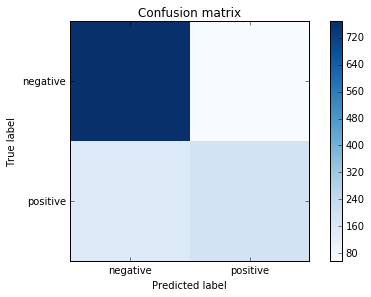

In [743]:
# we create an instance of Neighbours Classifier and fit the data.
sneigh = KNeighborsClassifier(n_neighbors=3, weights ='uniform')
sneigh.fit(sptr_ft, sptr_lb) 
spred = sneigh.predict(spvl_ft)
scm_kNN = confusion_matrix(spvl_lb, spred)
np.set_printoptions(precision=2)

print(scm_kNN)
plt.figure()
plot_confusion_matrix(scm_kNN)
plt.savefig('Confusion_spam_kNN.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 768           | 58       |
| positive      | 155           | 191      |

#### Metrics of evaluation

In [814]:
metrics(scm_kNN.T)

(0.71642250613357605, 0.81825938566552903, 0.87821612349914235)

### AdaBoost

[[788  38]
 [153 193]]


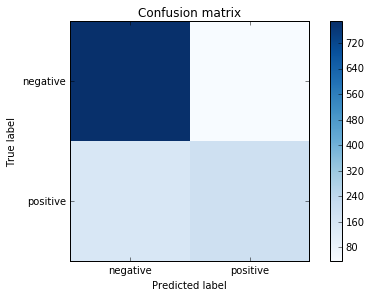

In [744]:
sbdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=1000)

sbdt.fit(sptr_ft, sptr_lb)


spred = sbdt.predict(spvl_ft)
scm_bdt = confusion_matrix(spvl_lb, spred)
np.set_printoptions(precision=2)

print(scm_bdt)
plt.figure()
plot_confusion_matrix(scm_bdt)
plt.savefig('Confusion_spam_AdaBoost.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 788           | 38       |
| positive      | 153           | 193      |

#### Metrics of evaluation

In [818]:
metrics(scm_bdt.T)

(0.72948050518370355, 0.83703071672354945, 0.89190718732314644)

### Gmean summary


|   Gmean       | linearSVM     | kNN      |  AdaBoost| Thin_linearSVM | Thin_kNN | Thin_AdaBoost|
| ------------- |:-------------:| --------:|---------:|---------------:|---------:|-------------:|
| spam          | 0.7456        | 0.7164   |  0.7295  |                | 
| easy          | 0.2781        | 0.4295   |  0.6837  | 0.2781         | 0.4451   | 0.5467       |
| diff          | 0.0           | 0.3812   |  0.3556  | 0.0            | 0.3812   | 0.4484       | 



### Thinning out

In [1372]:
X=etr0
y=elb0
neg = X[y == 0,:]
pos = X[y == 1,:]
m = len(neg)
n = len(pos)
ind = np.arange(m+n)
i = nr.choice(ind[y==0],1)[0]



In [1374]:
y[88]

0.0

In [1375]:
C = np.append(ind[y==1], [i])

tneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')
tneigh.fit(X[C,:], np.append(y[y==1],[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [1385]:
tpred = np.array(tneigh.predict(X))
mis_ind = (tpred != y)

In [1379]:
np.intersect1d(ind[mis_ind], C)

array([], dtype=int64)

In [1380]:
C

array([ 8, 14, 26, 31, 34, 39, 52, 70, 94, 88])

In [1387]:
C = np.append(C, ind[mis_ind])

In [1389]:
del_ind = []
j = n
distj = np.sum(np.square(X - X[C[j],:]), axis = 1)

In [1392]:
distj[C[j]] = 100000000000
distj[88]

100000000000.0

In [1395]:
minj = np.min(distj)
minj
len(distj)

100

In [1398]:
ind_min = np.logical_and(minj == distj, y == 1)

In [1411]:

del_ind = []
j = 45
distj = np.sum(np.square(X - X[C[j],:]), axis = 1)
distj[C[j]] = 100000000000
minj = np.min(distj)
ind_min = np.logical_and(minj == distj, y == 1)



In [1414]:
ind[ind_min]

array([31])

In [1417]:
distl = np.sum(np.square(X - X[31,:]), axis = 1)
distl[31]=100
np.min(distl)

0.38661995125530574

In [1418]:



cond = False
for l in ind[ind_min]:
    print(j)

    if (not cond):
        distl = np.sum(np.square(X - X[l,:]), axis = 1)
        distl[l] = 10000000

        cond = np.all(distl >= minj)

        if cond:
            del_ind += del_ind + [j]

print(del_ind)
C = np.delete(C, del_ind)

45
[45]


In [1433]:
def thin_out(X,y):
    neg = X[y == 0,:]
    pos = X[y == 1,:]
    m = len(neg)
    n = len(pos)
    ind = np.arange(m+n)
    i = nr.choice(ind[y==0],1)[0]
    
    C = np.append(ind[y==1], [i])
    
    tneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')
    tneigh.fit(X[C,:], np.append(y[y==1],[0])) 
    
    tpred = np.array(tneigh.predict(X))
    mis_ind = np.logical_and(tpred != y, y == 0)
    
    if mis_ind[i] == True:
        mis_ind[i] = False
    
    C = np.append(C, ind[mis_ind])
    

    del_ind = []
    for j in range(n, len(C)):
        distj = np.sum(np.square(X - X[C[j],:]), axis = 1)
        distj[C[j]] = 100000000000
        minj = np.min(distj)
        ind_min = np.logical_and(minj == distj, y == 1)
        
        cond = False
        for l in ind[ind_min]:
            
            if (not cond):
                distl = np.sum(np.square(X - X[l,:]), axis = 1)
                distl[l] = 1000000000
            
                cond = np.all(distl >= minj)
                
                if cond:
                    del_ind += [j]
                
    
    C = np.delete(C, del_ind)
    return C
        


In [1429]:
not False

True

In [1430]:
thin_out(dtr0, dlb0)

[37, 80]


array([15, 24, 47, 62, 65, 73, 78, 89, 91, 92,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26,
       27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64,
       66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 90, 93, 94, 95, 96, 97, 98])

### Thin out and linearSVM 

### Easy model

In [1440]:
m_ = len(ethlb0)
ran_ind = nr.choice(m_,m_,replace = False)
ethft0_ , ethlb0_ = ethft0[ran_ind,:], ethlb0[ran_ind]

In [1441]:
cv_linearSVM(ethft0_, ethlb0_, 1, 10)

3.8164965809277263

In [1442]:
cv_linearSVM(ethft0_, ethlb0_, 10, 10)

3.8164965809277263

In [1443]:
cv_linearSVM(ethft0_, ethlb0_, 0.1, 10)

0.0

In [1444]:
cv_linearSVM(ethft0_, ethlb0_, 5, 10)

3.8164965809277263

In [1445]:
cv_linearSVM(ethft0_, ethlb0_, 100, 10)

3.8164965809277263

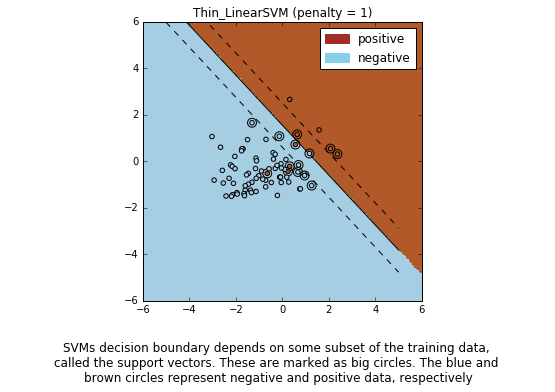

In [1446]:
penalty = 1
clf = svm.SVC(kernel='linear', C=penalty)


clf.fit(ethft0_, ethlb0_)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]
fignum=1
# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy + a * margin
yy_up = yy - a * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(5, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10)
plt.scatter(ethft0_[:, 0], ethft0_[:, 1], c=ethlb0_, zorder=10, cmap=plt.cm.Paired, s = 20)

plt.axis('tight')
x_min = -6
x_max = 6
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(fignum, figsize=(6, 6))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


#plt.xticks(())
#plt.yticks(())


brown_patch = mpatches.Patch(color='brown', label='positive')
sky_patch = mpatches.Patch(color='skyblue', label='negative')
plt.legend(handles=[brown_patch, sky_patch])
plt.title("Thin_LinearSVM (penalty = 1)")
plt.figtext(0.5, -0.1,'''SVMs decision boundary depends on some subset of the training data, 
                        called the support vectors. These are marked as big circles. The blue and 
                        brown circles represent negative and positive data, respectively''',
            wrap=True,horizontalalignment='center', fontsize=12)

plt.savefig('easy_thin_linearSVM.png', bbox_inches='tight')




[[90  2]
 [ 4  4]]


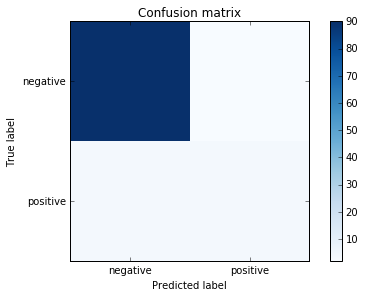

In [1447]:
# Compute confusion matrix
epred = clf.predict(etr[1000:1100,:])
ecm_thin_linearSVM = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)
print(ecm_thin_linearSVM)
plt.figure()
plot_confusion_matrix(ecm_thin_linearSVM)
plt.savefig('Confusion_easy_thin_linearSVM.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 90            | 2        |
| positive      | 4             | 4        |

#### Average metrics of evaluation

In [1448]:

def avg_thin_linearSVM (X, y, penalty, ind):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]
        
        
        X_train_ = X_train[ind[i], :]
        y_train_ = y_train[ind[i]]
        
        clf = svm.SVC(kernel='linear', C=penalty)
        clf.fit(X_train_, y_train_)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [1449]:
thin_linearSVM_gmean, thin_linearSVM_accur, thin_linearSVM_fmeas = avg_thin_linearSVM (etr, elb, 1, eind)

In [1450]:
np.mean(thin_linearSVM_gmean)

0.3349231635802965

In [1451]:
np.mean(thin_linearSVM_accur)

0.92222222222222228

In [1452]:
np.mean(thin_linearSVM_fmeas)

0.9589363899438994

#### Difficult model 

In [1453]:
m_= len(dthlb0)
ran_ind = nr.choice(m_,m_,replace = False)
dthlb0_ = dthlb0[ran_ind]
dthft0_ = dthft0[ran_ind, :]

In [1454]:
cv_linearSVM (dthft0_, dthlb0_, 1, 10) 

0.0

In [1455]:
cv_linearSVM (dthft0_, dthlb0_, 10, 10) 

0.0

In [1456]:
cv_linearSVM (dthft0_, dthlb0_, 100, 10) 

0.0

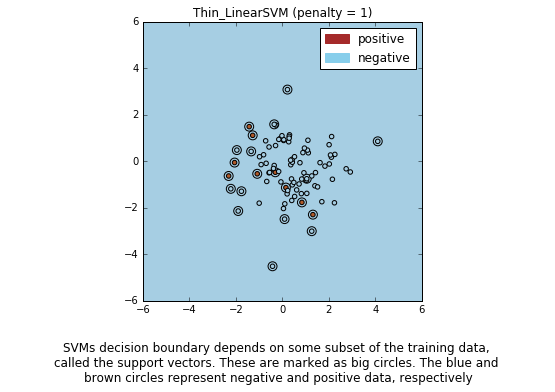

In [1457]:
penalty = 1
clf = svm.SVC(kernel='linear', C=penalty)


clf.fit(dthft0_, dthlb0_)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]
fignum=1
# plot the parallels to the separating hyperplane that pass through the
# support vectors
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy + a * margin
yy_up = yy - a * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(5, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10)
plt.scatter(dthft0_[:, 0], dthft0_[:, 1], c=dthlb0_, zorder=10, cmap=plt.cm.Paired, s = 20)

plt.axis('tight')
x_min = -6
x_max = 6
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(fignum, figsize=(6, 6))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


#plt.xticks(())
#plt.yticks(())


brown_patch = mpatches.Patch(color='brown', label='positive')
sky_patch = mpatches.Patch(color='skyblue', label='negative')
plt.legend(handles=[brown_patch, sky_patch])
plt.title("Thin_LinearSVM (penalty = 1)")
plt.figtext(0.5, -0.1,'''SVMs decision boundary depends on some subset of the training data, 
                        called the support vectors. These are marked as big circles. The blue and 
                        brown circles represent negative and positive data, respectively''',
            wrap=True,horizontalalignment='center', fontsize=12)

plt.savefig('diff_thin_linearSVM.png', bbox_inches='tight')


[[94  0]
 [ 6  0]]


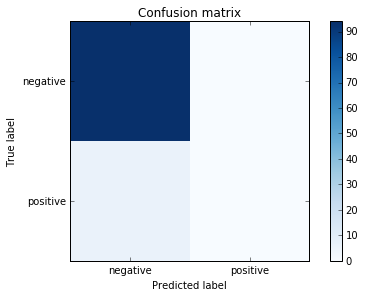

In [1458]:
# Compute confusion matrix
dpred = clf.predict(dtr[1000:1100,:])
dcm_thin_linearSVM = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)
print(dcm_thin_linearSVM)
plt.figure()
plot_confusion_matrix(dcm_thin_linearSVM)
plt.savefig('Confusion_diff_thin_linearSVM.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 94            | 0        |
| positive      | 6             | 0        |

In [1459]:
dthin_linearSVM_gmean, dthin_linearSVM_acurr, dthin_linearSVM_fmeas = avg_thin_linearSVM(dtr, dlb, 1, dind)

In [1460]:
np.mean(dthin_linearSVM_gmean)

0.0

In [1461]:
np.mean(dthin_linearSVM_acurr)

0.93999999999999995

In [1462]:
np.mean(dthin_linearSVM_fmeas)

0.9690721649484535

### Thin out and kNN

In [1463]:
cv_kNN(ethft0_, ethlb0_, 1, 10)

4.6329268809590989

In [1464]:
cv_kNN(ethft0_, ethlb0_, 3, 10)

3.8164965809277263

In [1465]:
cv_kNN(ethft0_, ethlb0_, 5, 10)

2.5773502691896257

In [1466]:
cv_kNN(ethft0_, ethlb0_, 7, 10)

2.0

In [1467]:
cv_kNN(ethft0_, ethlb0_, 9, 10)

1.0

In [1468]:
cv_kNN(ethft0_, ethlb0_, 11, 10)

1.0

In [ ]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


# we create an instance of Neighbours Classifier and fit the data.
tneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')

tneigh.fit(ethft0_, ethlb0_) 

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = tneigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(ethft0_[:, 0], ethft0_[:, 1], c=ethlb0_, cmap=cmap_bold, s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Thin_k-Nearest neighbors (k = %i, weights = '%s')"
          % (1, 'distance'))

green_patch = mpatches.Patch(color='green', label='positive')
red_patch = mpatches.Patch(color='red', label='negative')
plt.legend(handles=[green_patch, red_patch])

plt.savefig('easy_thin_kNN.png', bbox_inches='tight')

In [ ]:
# Compute confusion matrix
epred = tneigh.predict(etr[1000:1100,:])
ecm_thin_kNN = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)
print(ecm_thin_kNN)
plt.figure()
plot_confusion_matrix(ecm_thin_kNN)
plt.savefig('Confusion_easy_thin_kNN.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 85            | 7        |
| positive      | 6             | 2        |

In [1290]:
def avg_thin_kNN (X, y, k, ind):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]
        
        X_train_ = X_train[ind[i]]
        y_train_ = y_train[ind[i]]
        
        clf = KNeighborsClassifier(n_neighbors=k, weights ='uniform')
        clf.fit(X_train_, y_train_)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [1291]:
thin_kNN_gmean, thin_kNN_accur, thin_kNN_fmeas = avg_thin_kNN(etr, elb, 1, eind)

In [1292]:
np.mean(thin_kNN_gmean)

0.42890258602354553

In [1293]:
np.mean(thin_kNN_accur)

0.89777777777777779

In [1294]:
np.mean(thin_kNN_fmeas)

0.94489750218704116

#### Difficult model

In [1295]:
cv_kNN(dthft0_, dthlb0_, 1, 10)

0.93541434669348533

In [1296]:
cv_kNN(dthft0_, dthlb0_, 3, 10)

0.0

In [1297]:
cv_kNN(dthft0_, dthlb0_, 5, 10)

0.0

In [1299]:
cv_kNN(dthft0_, dthlb0_, 7, 10)

0.0

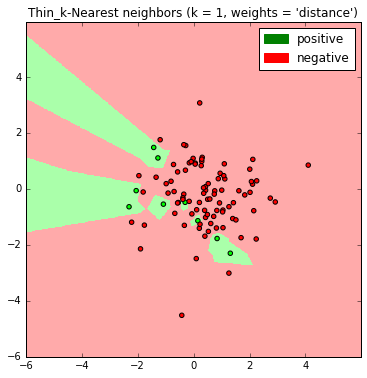

In [1301]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


# we create an instance of Neighbours Classifier and fit the data.
tneigh = KNeighborsClassifier(n_neighbors=1, weights ='uniform')

tneigh.fit(dthft0_, dthlb0_) 

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = tneigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6,6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(dthft0_[:, 0], dthft0_[:, 1], c=dthlb0_, cmap=cmap_bold, s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Thin_k-Nearest neighbors (k = %i, weights = '%s')"
          % (1, 'distance'))

green_patch = mpatches.Patch(color='green', label='positive')
red_patch = mpatches.Patch(color='red', label='negative')
plt.legend(handles=[green_patch, red_patch])

plt.savefig('diff_thin_kNN.png', bbox_inches='tight')

In [1303]:
len(dthft0)

97

[[83 11]
 [ 5  1]]


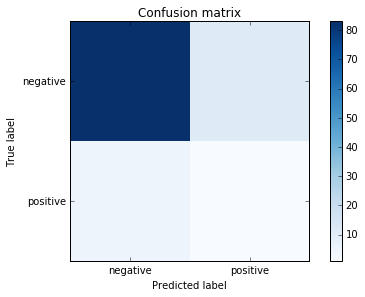

In [1103]:
# Compute confusion matrix
dpred = tneigh.predict(dtr[1000:1100,:])
dcm_thin_kNN = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)
print(dcm_thin_kNN)
plt.figure()
plot_confusion_matrix(dcm_thin_kNN)
plt.savefig('Confusion_diff_thin_kNN.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 83            | 11       |
| positive      | 5             | 1        |

#### Average metrics of evaluation

In [1104]:
dthin_kNN_gmean, dthin_kNN_accur, dthin_kNN_fmeas = avg_thin_kNN(dtr, dlb, 1)

In [1105]:
np.mean(dthin_kNN_gmean)

0.38117497103809805

In [1106]:
np.mean(dthin_kNN_accur)

0.87222222222222223

In [1107]:
np.mean(dthin_kNN_fmeas)

0.93063120046755088

### Thin out and AdaBoost

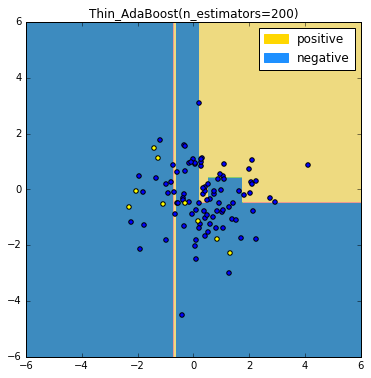

In [1108]:
# Create and fit an AdaBoosted decision tree
ebdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

thin_ind = thin_out(etr0, elb0)
etr0_,elb0_ = etr0[thin_ind,:], elb0[thin_ind]

ebdt.fit(etr0_, elb0_)

plot_colors = ['blue','yellow']
plot_step = 0.02



# Plot the decision boundaries
plt.figure()
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = ebdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, c in zip(range(2), plot_colors):
    idx = np.where(dlb0 == i)
    plt.scatter(dtr0[idx, 0], dtr0[idx, 1], c=c)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

gold_patch = mpatches.Patch(color='gold', label='positive')
blue_patch = mpatches.Patch(color='dodgerBlue', label='negative')
plt.legend(handles=[gold_patch, blue_patch])

plt.title('Thin_AdaBoost(n_estimators=200)')

plt.savefig('easy_thin_Adaboost.png', bbox_inches='tight')

[[72 20]
 [ 6  2]]


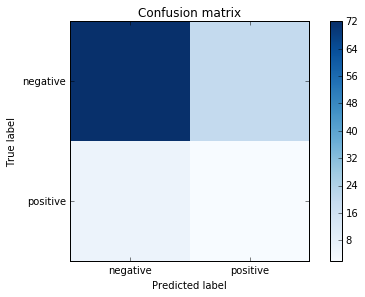

In [1109]:
# Compute confusion matrix
epred = ebdt.predict(dtr[1000:1100,:])
ecm_thin_AdaBoost = confusion_matrix(elb[1000:1100], epred)
np.set_printoptions(precision=2)
print(ecm_thin_AdaBoost)
plt.figure()
plot_confusion_matrix(ecm_thin_AdaBoost)
plt.savefig('Confusion_easy_thin_AdaBoost.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 72            | 20       |
| positive      | 6             | 2        |

In [1110]:
def avg_thin_AdaBoost (X, y):

    gmean = []
    fmeas = []
    accur = []    
    X_test = X[1000:1100, :]
    y_test = y[1000:1100]
    for i in range(1,10):
        
        X_train = X[i*100:(i+1)*100,:]
        y_train = y[i*100:(i+1)*100]
        
        
        thin_ind = thin_out(X_train, y_train)
        X_train_ = X_train[thin_ind, :]
        y_train_ = y_train[thin_ind]
        bdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

        bdt.fit(X_train_, y_train_)
        y_pred = bdt.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred).T

        if cm.shape == (1,1):
            new_cm = np.zeros((2,2))
            new_cm[0,0] = cm[0,0]
            cm = new_cm
        if cm[0,0]+ cm[1,0] == 0:
            a1 = 0
        else:
            
            a1 = cm[0,0]/(cm[0,0] + cm[1,0])
        if cm[1,1]+ cm[0,1] == 0:
            a0 = 0
        else:
            a0 = cm[1,1]/(cm[0,1] + cm[1,1])
            
        if cm[0,0]+ cm[0,1] == 0:
            p = 0
        else:
            p = cm[0,0]/(cm[0,0] + cm[0,1])
        
        if a1 + p == 0:
            f = 0
        else:
            f = (2 * p * a1)/(a1 + p)
        fmeas = fmeas + [f]
        gmean = gmean + [np.sqrt(a1 * a0)]
        accur = accur + [(cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[1,1]+cm[1,0]+ cm[0,1])]

    return gmean, accur, fmeas

In [1111]:
thin_AdaBoost_gmean, thin_AdaBoost_accur, thin_AdaBoost_fmeas = avg_thin_AdaBoost(etr,elb)

In [1112]:
np.mean(thin_AdaBoost_gmean)

0.54674905091880233

In [1113]:
np.mean(thin_AdaBoost_accur)

0.89777777777777779

In [1114]:
np.mean(thin_AdaBoost_fmeas)

0.94444870410238735

#### Difficult model

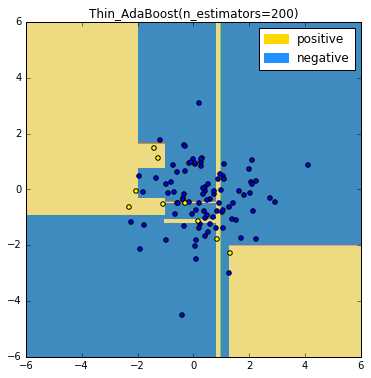

In [1116]:
# Create and fit an AdaBoosted decision tree
dbdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

thin_ind = thin_out(dtr0, dlb0)
dtr0_,dlb0_ = dtr0[thin_ind,:], dlb0[thin_ind]

dbdt.fit(dtr0_, dlb0_)

plot_colors = ['blue','yellow']
plot_step = 0.02



# Plot the decision boundaries
plt.figure()
x_min = -6
x_max = 6
y_min = -6
y_max = 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = dbdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, c in zip(range(2), plot_colors):
    idx = np.where(dlb0 == i)
    plt.scatter(dtr0[idx, 0], dtr0[idx, 1], c=c)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

gold_patch = mpatches.Patch(color='gold', label='positive')
blue_patch = mpatches.Patch(color='dodgerBlue', label='negative')
plt.legend(handles=[gold_patch, blue_patch])

plt.title('Thin_AdaBoost(n_estimators=200)')

plt.savefig('diff_thin_Adaboost.png', bbox_inches='tight')




[[83 11]
 [ 4  2]]


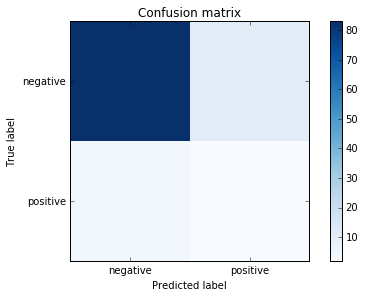

In [1117]:
# Compute confusion matrix
dpred = dbdt.predict(dtr[1000:1100,:])
dcm_thin_AdaBoost = confusion_matrix(dlb[1000:1100], dpred)
np.set_printoptions(precision=2)
print(dcm_thin_AdaBoost)
plt.figure()
plot_confusion_matrix(dcm_thin_AdaBoost)
plt.savefig('Confusion_diff_thin_AdaBoost.png', bbox_inches='tight')

In tabular form,

| true\prdicted | negative      | positive |
| ------------- |:-------------:| --------:|
| negative      | 83            | 11       |
| positive      | 4             | 2        |

In [1119]:
dthin_AdaBoost_gmean, dthin_AdaBoost_accur, dthin_AdaBoost_fmeas = avg_thin_AdaBoost(dtr,dlb)

In [1120]:
np.mean(dthin_AdaBoost_gmean)

0.44845425122134064

In [1121]:
np.mean(dthin_AdaBoost_accur)

0.84888888888888892

In [1122]:
np.mean(dthin_AdaBoost_fmeas)

0.91628783242878009

## Spam 

In [1135]:
test = thin_out(sptr_ft[:4000,:],sptr_lb[:4000])

In [1157]:
spth_ft, spth_lb = sptr_ft[test], sptr_lb[test]

In [1161]:
sio.savemat('thinned_spam',{'train_ft':spth_ft, 'train_lb':spth_lb, 'valid_ft':spvl_ft,'valid_lb':spvl_lb})

In [1162]:
spvl_ft.shape

(1172, 32)

In [1144]:
n_spam =4000
n_folds = 10
kf = KFold(n_spam, n_folds)
cv_spam_ft = []
cv_spam_lb = []
cv_spam_thin = []
for train_index, test_index in kf:
    cv_spam_thin = cv_spam_thin + [thin_out(sptr_ft[train_index,: ], sptr_lb[train_index])]
    cv_spam_ft = cv_spam_ft + [train_index]
    cv_spam_lb = cv_spam_lb + [test_index]

In [1143]:
len(cv_spam_ft)

10

In [ ]:
penalty = 10
sclf = svm.SVC(kernel='linear', C=penalty)
sclf.fit(sptr_ft, sptr_lb)
# Compute confusion matrix
spred = sclf.predict(spvl_ft)
scm_linearSVM = confusion_matrix(spvl_lb, spred)
np.set_printoptions(precision=2)
print(scm_linearSVM)

plt.figure()
plot_confusion_matrix(scm_linearSVM)
plt.savefig('Confusion_spam_linearSVM.png', bbox_inches='tight')

### Thinned data

In [1434]:
enew0 = thin_out(etr0,elb0) 
enew1 = thin_out(etr[100:200],elb[100:200])
enew2 = thin_out(etr[200:300],elb[200:300])
enew3 = thin_out(etr[300:400],elb[300:400])
enew4 = thin_out(etr[400:500],elb[400:500])
enew5 = thin_out(etr[500:600],elb[500:600])
enew6 = thin_out(etr[600:700],elb[600:700])
enew7 = thin_out(etr[700:800],elb[700:800])
enew8 = thin_out(etr[800:900],elb[800:900])
enew9 = thin_out(etr[900:1000],elb[900:1000])


eind = [enew0,enew1,enew2,enew3,enew4,enew5,enew6,enew7,enew8,enew9]

In [1435]:
dnew0 = thin_out(dtr0,dlb0) 
dnew1 = thin_out(dtr[100:200],dlb[100:200])
dnew2 = thin_out(dtr[200:300],dlb[200:300])
dnew3 = thin_out(dtr[300:400],dlb[300:400])
dnew4 = thin_out(dtr[400:500],dlb[400:500])
dnew5 = thin_out(dtr[500:600],dlb[500:600])
dnew6 = thin_out(dtr[600:700],dlb[600:700])
dnew7 = thin_out(dtr[700:800],dlb[700:800])
dnew8 = thin_out(dtr[800:900],dlb[800:900])
dnew9 = thin_out(dtr[900:1000],dlb[900:1000])

dind = [dnew0,dnew1,dnew2,dnew3,dnew4,dnew5,dnew6,dnew7,dnew8,dnew9]

In [1436]:
ethft0, ethlb0 = etr0[enew0], elb0[enew0]
ethft1, ethlb1 = etr[100:200][enew1], elb[100:200][enew1]
ethft2, ethlb2 = etr[200:300][enew2], elb[200:300][enew2]
ethft3, ethlb3 = etr[300:400][enew3], elb[300:400][enew3]
ethft4, ethlb4 = etr[400:500][enew4], elb[400:500][enew4]
ethft5, ethlb5 = etr[500:600][enew5], elb[500:600][enew5]
ethft6, ethlb6 = etr[600:700][enew6], elb[600:700][enew6]
ethft7, ethlb7 = etr[700:800][enew7], elb[700:800][enew7]
ethft8, ethlb8 = etr[800:900][enew8], elb[800:900][enew8]
ethft9, ethlb9 = etr[900:1000][enew9], elb[900:1000][enew9]

In [1437]:
sio.savemat('thinned_easy',{'feat0': ethft0, 'label0': ethlb0,
                           'feat1': ethft1, 'label1': ethlb1,
                           'feat2': ethft2, 'label2': ethlb2,
                            'feat3': ethft3, 'label3': ethlb3,
                           'feat4': ethft4, 'label4': ethlb4,
                           'feat5': ethft5, 'label5': ethlb5,
                           'feat6': ethft6, 'label6': ethlb6,
                           'feat7': ethft7, 'label7': ethlb7,
                           'feat8': ethft8, 'label8': ethlb8,
                           'feat9': ethft9, 'label9': ethlb9})

In [1438]:
dthft0, dthlb0 = dtr0[dnew0], dlb0[dnew0]
dthft1, dthlb1 = dtr[100:200][dnew1], dlb[100:200][dnew1]
dthft2, dthlb2 = dtr[200:300][dnew2], dlb[200:300][dnew2]
dthft3, dthlb3 = dtr[300:400][dnew3], dlb[300:400][dnew3]
dthft4, dthlb4 = dtr[400:500][dnew4], dlb[400:500][dnew4]
dthft5, dthlb5 = dtr[500:600][dnew5], dlb[500:600][dnew5]
dthft6, dthlb6 = dtr[600:700][dnew6], dlb[600:700][dnew6]
dthft7, dthlb7 = dtr[700:800][dnew7], dlb[700:800][dnew7]
dthft8, dthlb8 = dtr[800:900][dnew8], dlb[800:900][dnew8]
dthft9, dthlb9 = dtr[900:1000][dnew9], dlb[900:1000][dnew9]


In [1439]:
sio.savemat('thinned_diff',{'feat0': dthft0, 'label0': dthlb0,
                           'feat1': dthft1, 'label1': dthlb1,
                           'feat2': dthft2, 'label2': dthlb2,
                            'feat3': dthft3, 'label3': dthlb3,
                           'feat4': dthft4, 'label4': dthlb4,
                           'feat5': dthft5, 'label5': dthlb5,
                           'feat6': dthft6, 'label6': dthlb6,
                           'feat7': dthft7, 'label7': dthlb7,
                           'feat8': dthft8, 'label8': dthlb8,
                           'feat9': dthft9, 'label9': dthlb9})